In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Data

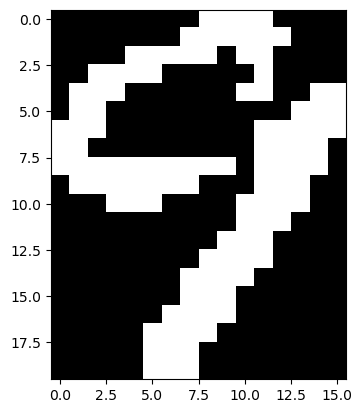

In [2]:
alpha_digit = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]
plt.imshow(alpha_digit[9][0], cmap="gray")


Shape (36, 39)


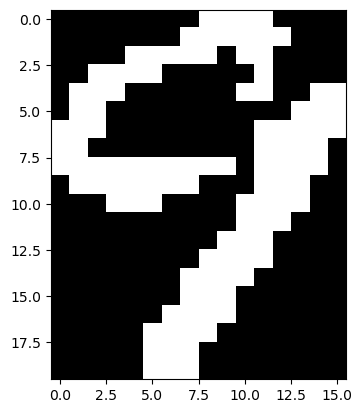

In [3]:
alpha_digit = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

print("Shape", alpha_digit.shape)

plt.imshow(alpha_digit[9][0], cmap="gray")
plt.show()

In [4]:
def lire_alpha_digit(alpha_digits, chars):
    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)

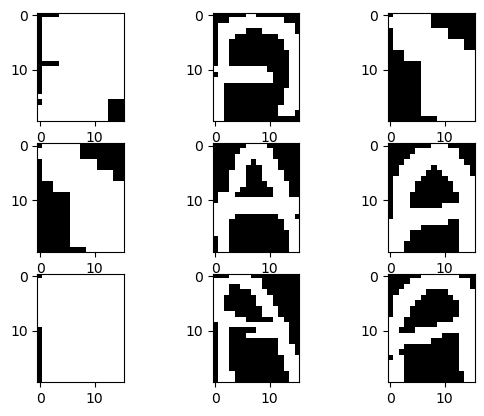

In [5]:
data_digits, labels_digits = lire_alpha_digit(alpha_digit, ["1", "A"])
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, data_digits.shape[0])
        axs[i, j].imshow(data_digits[idx].reshape(20, 16), cmap="gray")
plt.show()

In [6]:
#idx =10
#plt.imshow(data_digits[idx].reshape(20, 16), cmap="gray")
print(set(labels_digits))

{1, 10}


# Fonctions élémentaires

## RBM

In [7]:
class RBM:
    def __init__(self, p, q):
        self.W = np.random.normal(loc=0, scale=np.sqrt(0.01), size=(p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)


def init_RBM(p, q):
    return RBM(p, q)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def entree_sortie_RBM(rbm, X):
    return sigmoid(np.dot(X, rbm.W) + rbm.b)


def sortie_entree_RBM(rbm, H):
    return sigmoid(np.dot(H, rbm.W.T) + rbm.a)


def train_RBM(rbm, X, epochs, lr, batch_size):
    p, q = rbm.W.shape
    n = X.shape[0]
    for epoch in range(epochs):
        X_copy = X.copy()
        np.random.shuffle(X_copy)

        for i in range(0, n, batch_size):
            v_0 = X_copy[i : i + batch_size]
            tb = len(v_0)
            es_v_0 = entree_sortie_RBM(rbm, v_0)
            h_0 = (np.random.uniform(size=(tb, q)) < es_v_0).astype("float")
            v_1 = (
                np.random.uniform(size=(tb, p)) < sortie_entree_RBM(rbm, h_0)
            ).astype("float")
            h_1 = entree_sortie_RBM(rbm, v_1)

            rbm.W += lr / tb * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
            rbm.a += lr / tb * np.sum(v_0 - v_1, axis=0)
            rbm.b += lr / tb * np.sum(es_v_0 - h_1, axis=0)


def generer_image_RBM(rbm, gibbs_iter, n_image):
    p, q = rbm.W.shape
    X = np.zeros((n_image, p))
    for i in range(n_image):
        x = (np.random.uniform(size=p) < 0.5).astype("float")

        for iter in range(gibbs_iter):
            h = (np.random.uniform(size=q) < entree_sortie_RBM(rbm, x)).astype("float")
            x = (np.random.uniform(size=p) < sortie_entree_RBM(rbm, h)).astype("float")

        X[i] = x
    return X

## DBN

In [430]:
class DBN:
    def __init__(self, n_layers):
        self.rbm = []
        #self.rbm.append(RBM(784, n_layers[0]))
        for i in range(len(n_layers)-1):
            self.rbm.append(RBM(n_layers[i], n_layers[i + 1]))
        
        
    """def init_RBMs(self, layers):
        rbms = []
        for l in layers:
            rbm = init_RBM(p, l)
            rbms.append(rbm)
            p = l
        return rbms"""


def init_DBN(layers):
    return DBN(320, layers)


def train_DBN(dbn, X_init, epochs, lr, batch_size):
    for epoch in range(epochs):
        X = X_init
        for rbm in dbn.rbm:
            # print("shape", X.shape, rbm.W.shape, rbm.b.shape)
            train_RBM(rbm, X, epochs, lr, batch_size)
            X = entree_sortie_RBM(rbm, X)
    return dbn


def generer_image_DBN(dbn, gibbs_iter, n_image):
    X = generer_image_RBM(dbn.rbm[-1], gibbs_iter, n_image)
    for i in range(len(dbn.rbm) - 2, -1, -1):
        X = sortie_entree_RBM(dbn.rbm[i], X)
    return X

## DNN

In [445]:

def init_DNN( layers):
      dnn = DBN(layers)
      return dnn


def pretrain_DNN(dnn, X_init, epochs, lr, batch_size) :
      for epoch in range(epochs):
            X = X_init
            for rbm in dnn.rbm[:-1]:
                  # print("shape", X.shape, rbm.W.shape, rbm.b.shape)
               
                  train_RBM(rbm, X, epochs, lr, batch_size)
                  X = entree_sortie_RBM(rbm, X)
      return dnn  

#def soaftmax(x): 
      #return  

def calcul_softmax(x):
      return np.exp(x).T/np.sum(np.exp(x),axis=1)
      
def entree_sortie_reseau(dnn, X_init):
      sorties = []
      probabilites = []
      X = X_init
      sorties.append(X_init)
      compteur = 1
      for rbm in dnn.rbm[:-1]: 
            #print(compteur)
            sortie = entree_sortie_RBM(rbm,X)
            #print(sortie)
            #print(len(probabilite))
            X = sortie
            sorties.append(sortie)
            compteur+=1

      sortie = entree_sortie_RBM(dnn.rbm[-1],X)  
      probabilite = calcul_softmax(sortie)
      sorties.append(probabilite)
      return sorties


def retropropagation(dnn,X, epochs, lr, batch_size, label):
      #label = np.where(label==10,1,0)
      for epoch in range(epochs) :
            sorties = entree_sortie_reseau(dnn, X)
            dZ = sorties[-1].T - label
            for i in range(2,0,-1) : 
                  #print("yes0")
                  #print(sorties[i-1].shape)
                  #print(dZ.shape)
                  non = (lr/X.shape[0])* np.dot(sorties[i-1].T,dZ)
                  #print(non.shape)
                  #print(dnn.rbm[i].W.shape)
                  dnn.rbm[i].W = dnn.rbm[i].W  - (lr/X.shape[0])* np.dot(sorties[i-1].T,dZ)
                  
                  print("1")
                  dnn.rbm[i].b =dnn.rbm[i].b -  (lr/X.shape[0])*np.sum(dZ,axis=0)
                  print("2")
                  dA = np.dot(dZ,dnn.rbm[i].W.T)
                  print("3") 
                  print(dA.shape)
                  print(sorties[i-1].shape)
                  print(np.dot(sorties[i-1].T,(1-sorties[i-1])).shape)
                  
                  dZ = np.dot(dA, np.dot(sorties[i-1].T,(1-sorties[i-1])))
      return dnn

In [414]:
""""----------------------------IMPORTATION  DATASET ----------------------"""
from keras.datasets import mnist
#dataset mnist
def lire_mnist(subsample_size=-1):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # subsample to 1000 samples
    if subsample_size != -1:
        X_train = X_train[:subsample_size]
        y_train = y_train[:subsample_size]
        X_test = X_test[:subsample_size]
        y_test = y_test[:subsample_size]

    # to binary and flatten
    X_train_bin = (X_train >= 128).astype(int).reshape(X_train.shape[0], -1)
    X_test_bin = (X_test >= 128).astype(int).reshape(X_test.shape[0], -1)

    # one hot encode
    y_train = one_hot_encode(y_train)
    y_test = one_hot_encode(y_test)
    return X_train_bin, X_test_bin, y_train, y_test

def one_hot_encode(y):
    unique_labels = np.unique(y)
    y_ohe = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(y.shape[0]):
        y_ohe[i, np.where(unique_labels == y[i])] = 1
    return y_ohe

X_train_bin, X_test_bin, y_train, y_test = lire_mnist(subsample_size=-1)


#dataset digits
data, label = lire_alpha_digit(alpha_digit, vsmall)
print("Nombre d'images : " ,len(label))
print("Nombre d'images et nbr de pixels par image : ",data.shape)
print("Format image : ", n_rows,"*", n_cols)

Nombre d'images :  78
Nombre d'images et nbr de pixels par image :  (78, 320)
Format image :  20 * 16


In [431]:
"""  -------------------DEFINIR LES VARIABLES---------------------   """
layers = [784,100,100,10]  #320
epochs = 1
lr = 0.1
batch_size = 10

n_rows = 20
n_cols = 16

input_size = n_rows * n_cols
vsmall = ["0", "A"]
print("Unique label", set(label),"=",vsmall )
print(type(label))

Unique label {0, 10} = ['0', 'A']
<class 'numpy.ndarray'>


In [446]:
test = init_DNN(layers)
dnn = pretrain_DNN(test,X_train_bin , epochs, lr, batch_size)
#sorties = entree_sortie_reseau(dnn, X_train_bin)
dnn = retropropagation(dnn, X_train_bin, epochs, lr, batch_size, y_train)



1
2
3
(60000, 100)
(60000, 100)
(100, 100)


ValueError: operands could not be broadcast together with shapes (100,100) (784,100) 

In [433]:
print(dnn.rbm[0].W.shape)
print(dnn.rbm[1].W.shape)
print(dnn.rbm[2].W.shape)

(784, 100)
(100, 100)
(100, 10)


# 4. Etude sur Binary AlphaDigit

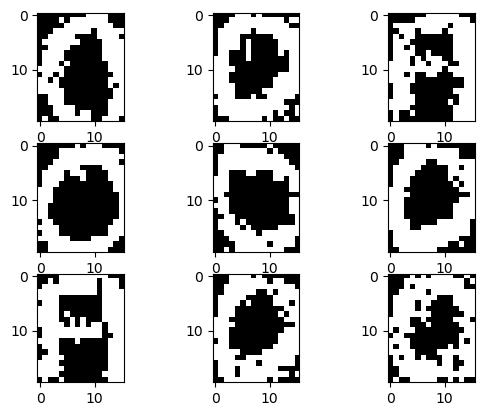

In [ ]:
layers = [100, 80]
epochs = 100
lr = 0.1
batch_size = 10
gibbs_iter = 100
n_image = 9

n_rows = 20
n_cols = 16
input_size = n_rows * n_cols

vsmall = ["0", "A"]
small = ["0", "1", "2"]
medium = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
extra_large = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
]

data, _ = lire_alpha_digit(alpha_digit, vsmall)

rbm = init_RBM(input_size, q=100)

train_RBM(rbm, data, epochs, lr, batch_size)

X_gen = generer_image_RBM(rbm, gibbs_iter, n_image)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_gen.reshape(-1, n_rows, n_cols)[i], cmap="gray")
plt.show()

In [ ]:
dbn = init_DBN([100, 80])
train_DBN(dbn, data, epochs, lr, batch_size)

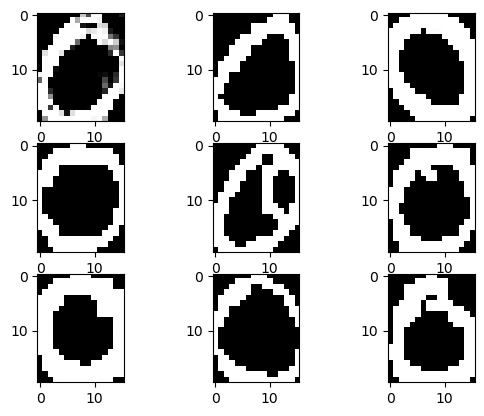

In [ ]:
X_gen = generer_image_DBN(dbn, gibbs_iter, n_image)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_gen.reshape(-1, n_rows, n_cols)[i], cmap="gray")
plt.show()